<h1 style="text-align: center">
Deep Learning HW3 </br>
VAE and CVAE
</h1>


### Full Name: Borna khodabandeh
### Student ID: 400109898

# Import necessary libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
# import torchvision

# Define the MNIST dataset and data loader

In [2]:
import os
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
# I added the num_workers=os.cpu_count(), pin_memory=False statements
batch_size = 100
x_dim = 28 * 28
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count(), pin_memory=False)

100%|██████████| 9912422/9912422 [00:02<00:00, 3606718.14it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 28855572.61it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100%|██████████| 1648877/1648877 [00:01<00:00, 909877.24it/s] 


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 4542/4542 [00:00<00:00, 4561908.23it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



# Data Visualization

In [3]:
# Function to display an image
def show_image(image, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

# Function to show random images from each class
def show_random_images_from_each_class(dataset, num_images_per_class=4, figsize=(10, 20)):
    class_labels = list(range(10))  
    fig, axs = plt.subplots(len(class_labels), num_images_per_class, figsize=figsize) 

    for i, label in enumerate(class_labels):
        class_indices = [idx for idx, target in enumerate(dataset.targets) if target == label]
        random_indices = random.sample(class_indices, num_images_per_class)

        for j, idx in enumerate(random_indices):
            image, target = dataset[idx]
            axs[i, j].imshow(image[0], cmap='gray')
            axs[i, j].set_title(f"Class {label}", fontsize=16)
            axs[i, j].axis('off')
            axs[i, j].set_aspect('equal')  
            axs[i, j].grid(True)

    plt.tight_layout()
    plt.show()

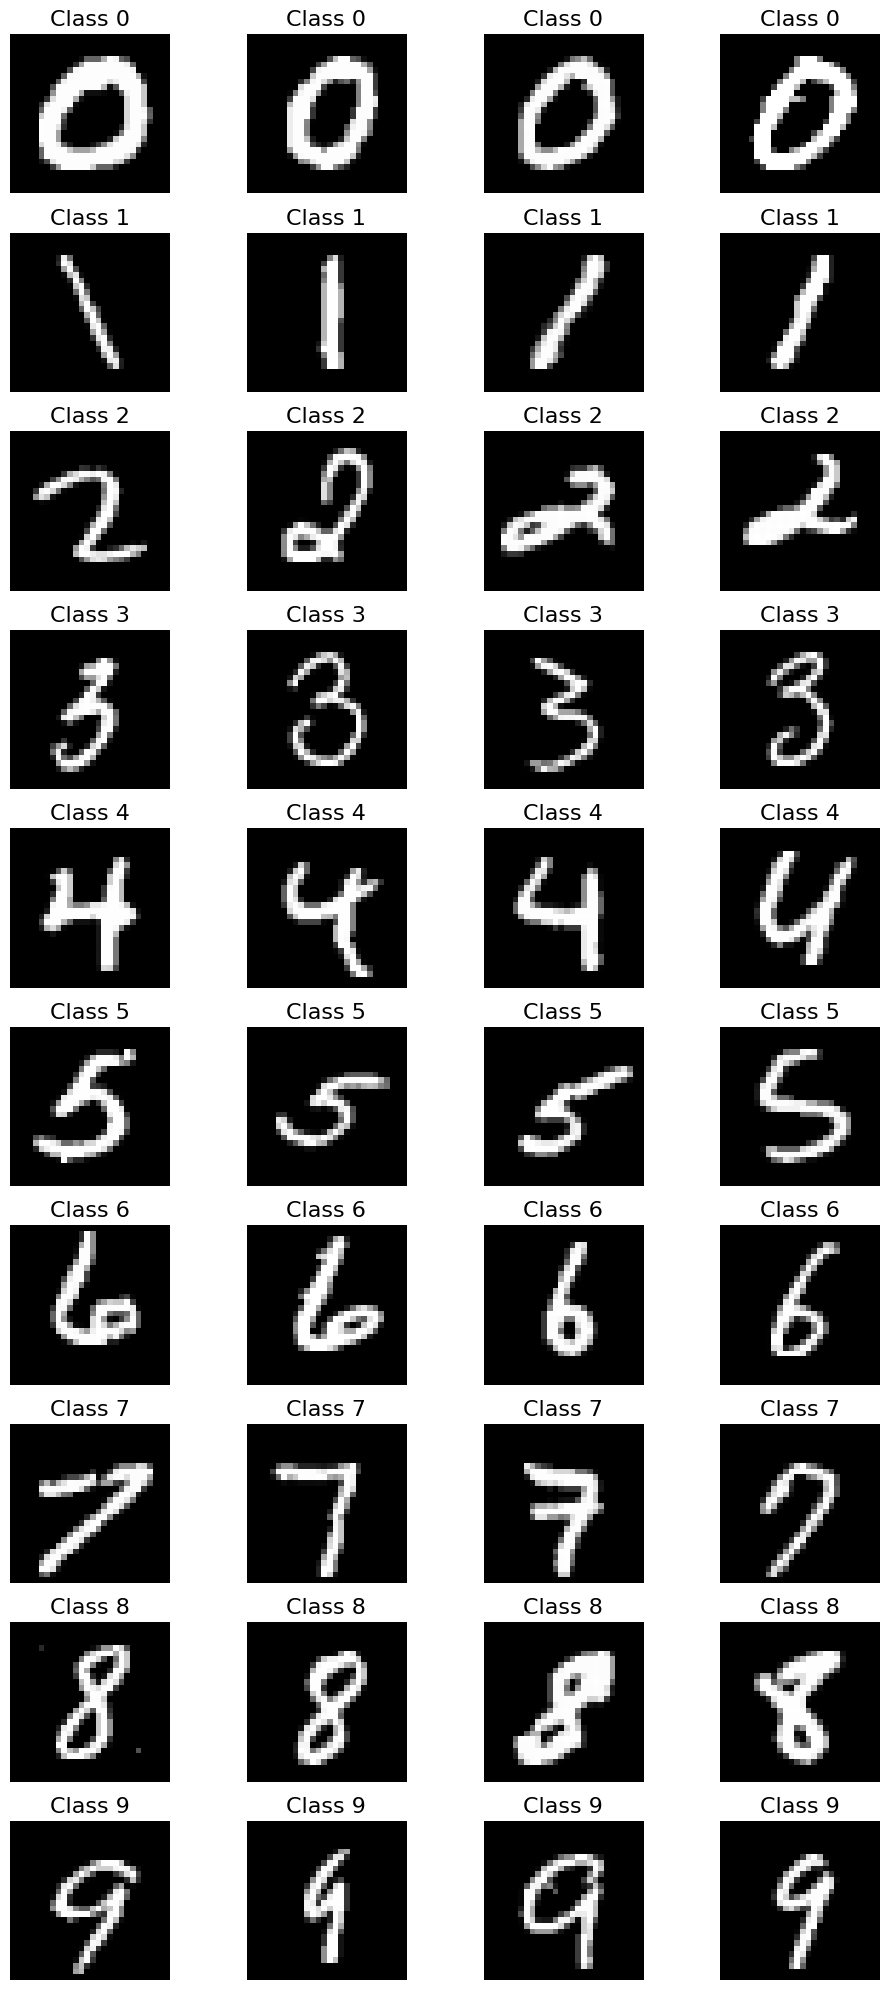

In [4]:
# Use the function to show random images from each class
show_random_images_from_each_class(train_dataset, num_images_per_class=4)

Exercise: Variational Autoencoders (VAE) and Conditional Variational Autoencoders (CVAE)

with MLP Architectures

In this exercise, we'll explore Variational Autoencoders (VAE) and Conditional VAE (CVAE) using PyTorch.

We will implement these models using Multi-Layer Perceptrons (MLP) 

Let's get started!

# 1) VAE --> MLP

In [5]:
# Define a simple VAE class with MLP architecture

class VAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE_MLP, self).__init__()
        # TODO: Define the architecture of the encoder and decoder
        self.encoder = nn.Sequential(
            # TODO: Add layers for the encoder
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.decoder = nn.Sequential(
            # TODO: Add layers for the decoder
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        # TODO: Implement the reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # TODO: Implement the forward pass
            
        x = x.view(-1, self.encoder[0].in_features)
        # Encode
        x = self.encoder(x)
        # Sample
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        z = z.to(x.device)
        # Decode
        reconstructed = self.decoder(z)
        return reconstructed, mu, logvar

In [6]:
# Define VAE loss function

def vae_loss(recon, data, mu, logvar):
    # TODO: Implement the reconstruction loss
    # Training on MNIST, so we chose to use BCE loss
    reconstruction_loss = F.binary_cross_entropy(recon, data, reduction = "sum")
#     reconstruction_loss = F.mse_loss(recon, data)
    # TODO: Implement the KL divergence loss
    kl_divergence = - 0.5 * torch.sum(
        1+ logvar - mu.pow(2) - logvar.exp()
    )

    # TODO: Return the total loss as the sum of reconstruction and KL divergence losses
    return reconstruction_loss + kl_divergence

In [7]:
# Training Loop - VAE (MLP)
def train_vae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.train()
    device = next(model.parameters()).device
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):

            # TODO: Forward process
            data = data.to(device)
            optimizer.zero_grad()
            
            recon, mu, logvar = model(data)
            # TODO: Flatten the data and recon tensors
            data = data.view(-1)
            recon = recon.view(-1)

            # TODO: Calculate the loss using the vae_loss function
            loss = vae_loss(recon, data, mu, logvar)

            # TODO: Backpropagation and optimization step
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f'VAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_samples = 6  # Generate num_samples random samples
#                 sample = torch.randn(num_samples, 20)
                sample = torch.randn(num_samples, 2)
                sample = sample.to(device)
                sample = model.decoder(sample).view(num_samples, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_samples, figsize=(15, 2))
                for i in range(num_samples):
                    axs[i].imshow(sample[i].cpu(), cmap='gray')
                    axs[i].axis('off')
                plt.show()

        # TODO: Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()  # TODO: Save the model

    # TODO: Save the best model to a file
    torch.save(best_model, 'best_vae_mlp_model.pth')
    print("Best model saved as 'best_vae_mlp_model.pth'")



##################################################
VAE-MLP Epoch [1/10], Loss: 18366.999225260417
Sample Images:


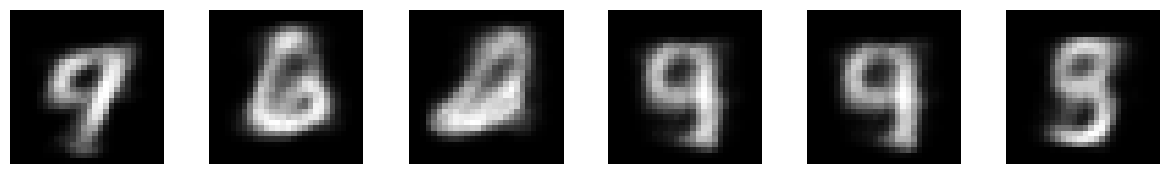


##################################################
VAE-MLP Epoch [2/10], Loss: 15571.123173828126
Sample Images:


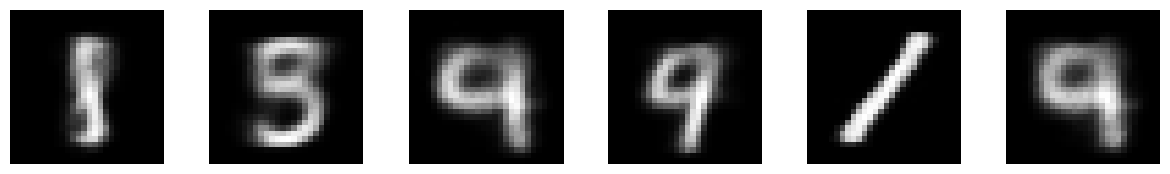


##################################################
VAE-MLP Epoch [3/10], Loss: 14885.396333007813
Sample Images:


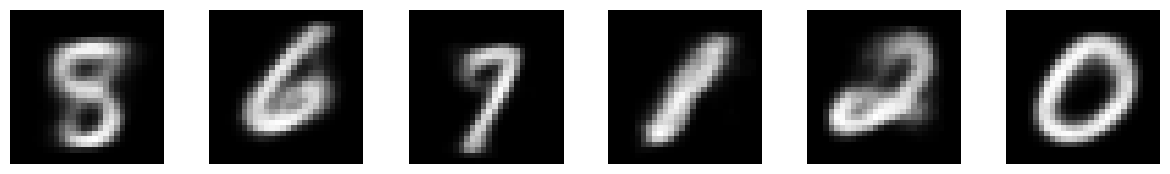


##################################################
VAE-MLP Epoch [4/10], Loss: 14608.623146158854
Sample Images:


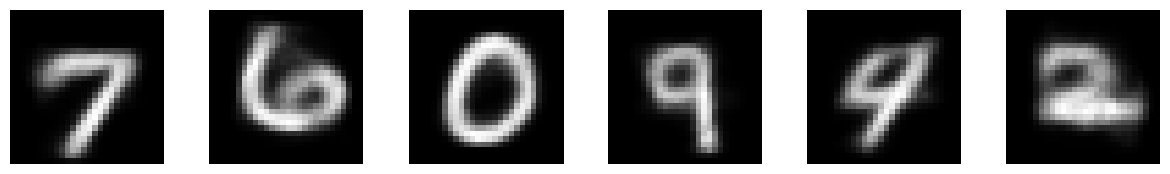


##################################################
VAE-MLP Epoch [5/10], Loss: 14478.974295247395
Sample Images:


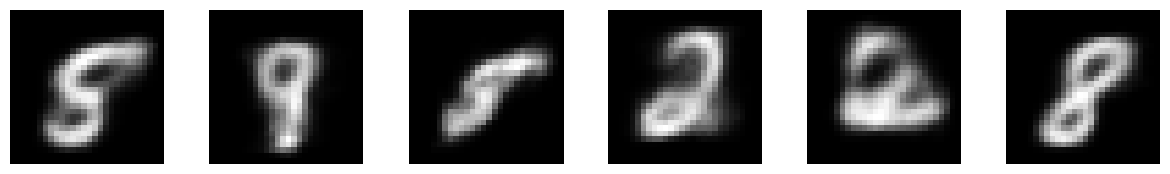


##################################################
VAE-MLP Epoch [6/10], Loss: 14340.06438639323
Sample Images:


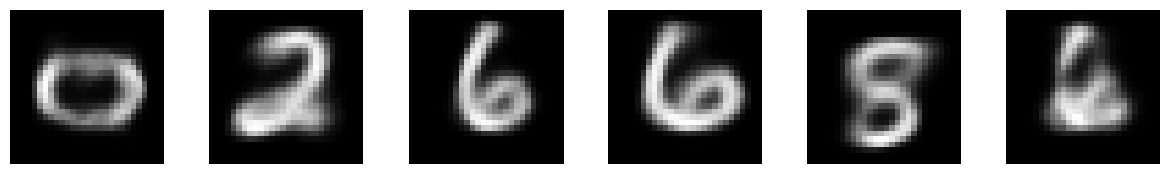


##################################################
VAE-MLP Epoch [7/10], Loss: 14237.36110188802
Sample Images:


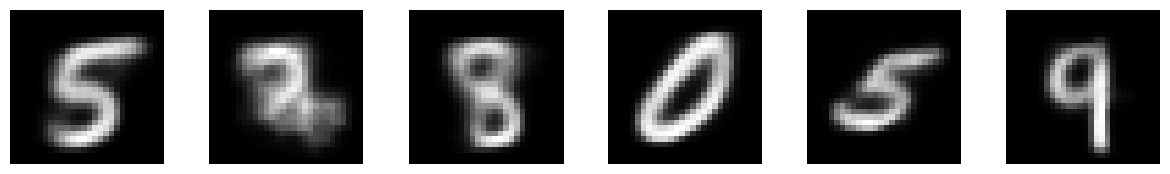


##################################################
VAE-MLP Epoch [8/10], Loss: 14191.746813151041
Sample Images:


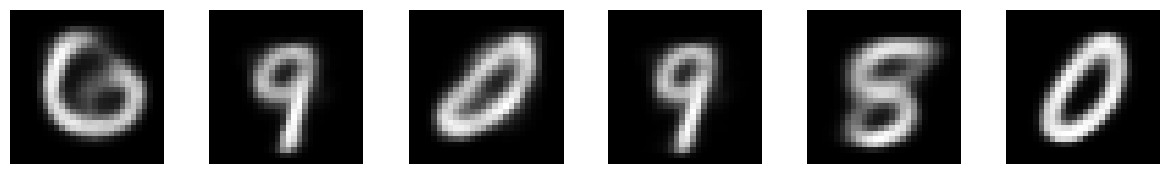


##################################################
VAE-MLP Epoch [9/10], Loss: 14097.699661458333
Sample Images:


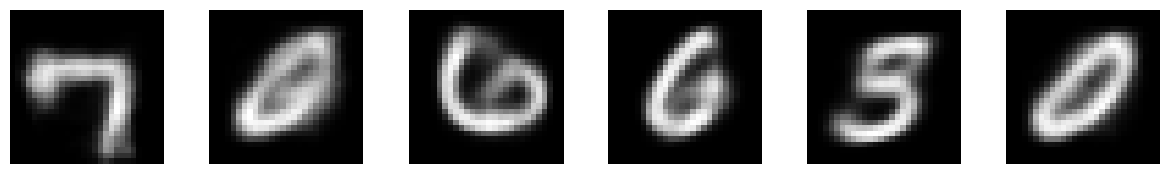


##################################################
VAE-MLP Epoch [10/10], Loss: 14046.336225585937
Sample Images:


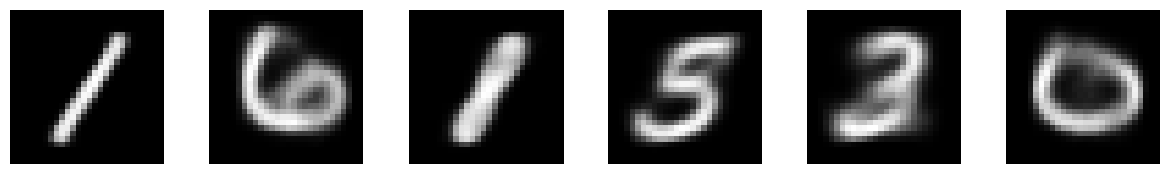

Best model saved as 'best_vae_mlp_model.pth'


In [8]:
# Train VAE-MLP
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae_mlp = VAE_MLP(x_dim, 512, 2)
vae_mlp = vae_mlp.to(device)
train_vae_mlp(vae_mlp, train_loader, learning_rate=0.001)

# 2) CVAE --> MLP

In [9]:
# Define a simple CVAE class with MLP architecture

class CVAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes):
        super(CVAE_MLP, self).__init__()
        # TODO: Define the architecture of the encoder
        self.encoder = nn.Sequential(
            # TODO: Add layers for the encoder
            nn.Linear(input_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc_class = nn.Linear(hidden_dim, num_classes)
        self.decoder = nn.Sequential(
            # TODO: Add layers for the decoder
            nn.Linear(latent_dim + num_classes, hidden_dim),
#             nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        # TODO: Implement the reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, y):
        x = x.view(x.size(0), -1)
        y = y.view(y.size(0), -1)

        # TODO: Concatenate x and y before passing them to the encoder
        x = torch.cat([x, y], dim=1)
        
        # TODO: Implement the forward pass
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        z = self.reparameterize(mu, logvar)
        class_logits = self.fc_class(hidden)
        
        z_cat = torch.cat([z, y], dim=1)     
#         z_cat = z
        reconstructed = self.decoder(z_cat)
        
        return reconstructed, mu, logvar, class_logits


In [10]:
# Define CVAE loss function
def cvae_loss(recon, data, mu, logvar, class_logits, labels):
    # TODO: Flatten the data tensor
    data = data.view(-1)
    recon = recon.view(-1)

    # TODO: Implement the reconstruction loss
    reconstruction_loss = F.binary_cross_entropy(recon, data, reduction = "sum")

    # TODO: Implement the KL divergence loss
    kl_divergence = - 0.5 * torch.sum(
        1+ logvar - mu.pow(2) - logvar.exp()
    )

    # TODO: Implement the cross-entropy loss for class prediction
    ce_loss = F.cross_entropy(class_logits, labels, reduction="sum")

    # TODO: Return the total loss as the sum of reconstruction, KL divergence, and cross-entropy losses
    return reconstruction_loss + kl_divergence + ce_loss


In [11]:
# Training Loop - CVAE (MLP)
def train_cvae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    device = next(model.parameters()).device
    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            # One-hot encode the labels
            labels_one_hot = F.one_hot(labels, num_classes=-1)

            # TODO: Forward pass through the model and calculate the loss using cvae_loss
            recon, mu, logvar, class_logits = model(data, labels_one_hot)
            loss = cvae_loss(recon, data, mu, logvar, class_logits, labels)

            # TODO: Backpropagation and optimization step
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f'CVAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_classes = 10  # Number of classes (0 to 9)
                num_samples_per_class = 1  # One sample per class
                # Generate random samples
                z = torch.randn(num_classes * num_samples_per_class, 2)
                # Generate one-hot encoded class labels
                y = torch.eye(num_classes).repeat(num_samples_per_class, 1)
                # Concatenate the random samples and class labels before passing them to the decoder
                sample = torch.cat([z, y], dim=1)
                sample = sample.to(device)
                sample = model.decoder(sample).view(num_classes * num_samples_per_class, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_classes, figsize=(15, 2))
                for i in range(num_classes):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].set_title(f"Class {i}", fontsize=16)
                    axs[i].axis('off')
                plt.show()

        # TODO: Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()

    # TODO: Save the best model to a file
    torch.save(best_model, 'best_cvae_mlp_model.pth')
    print("Best model saved as 'best_cvae_mlp_model.pth'")



##################################################
CVAE-MLP Epoch [1/10], Loss: 16566.704576822918
Sample Images:


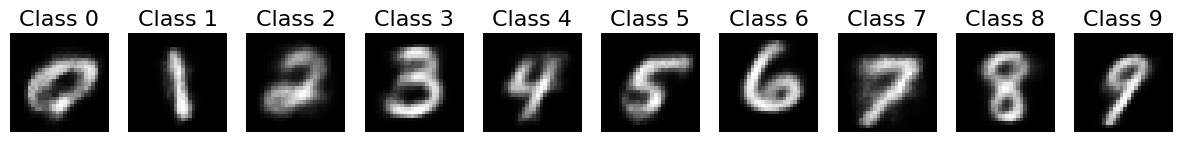


##################################################
CVAE-MLP Epoch [2/10], Loss: 13941.513666992187
Sample Images:


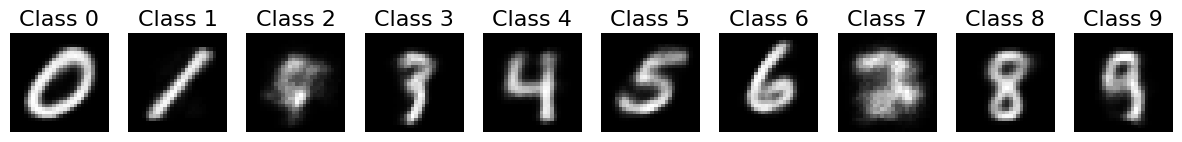


##################################################
CVAE-MLP Epoch [3/10], Loss: 13524.375784505208
Sample Images:


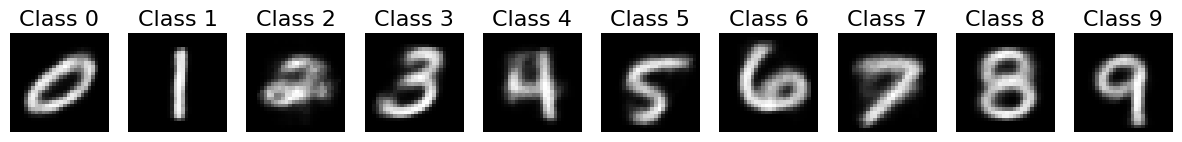


##################################################
CVAE-MLP Epoch [4/10], Loss: 13315.761791992187
Sample Images:


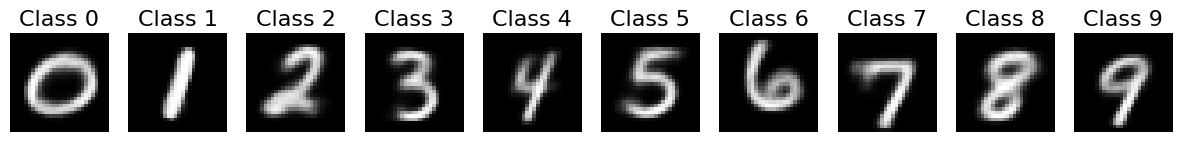


##################################################
CVAE-MLP Epoch [5/10], Loss: 13189.337967122396
Sample Images:


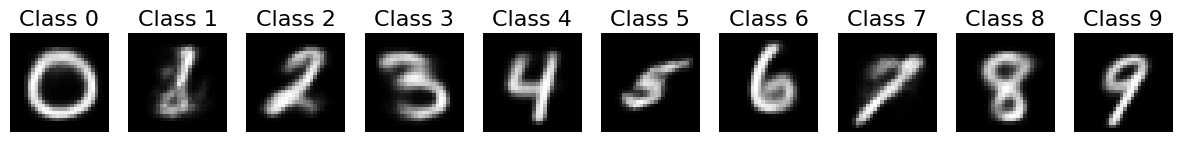


##################################################
CVAE-MLP Epoch [6/10], Loss: 13108.966468098959
Sample Images:


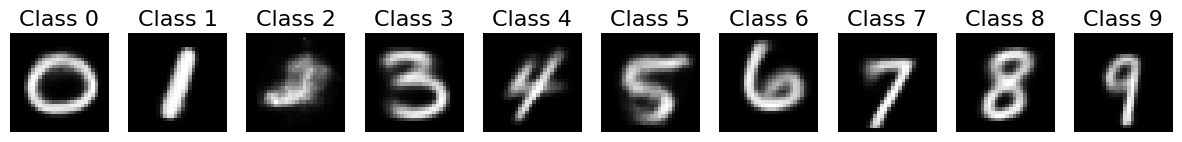


##################################################
CVAE-MLP Epoch [7/10], Loss: 13055.719851888021
Sample Images:


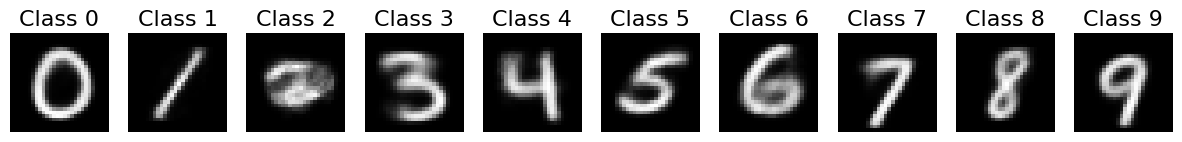


##################################################
CVAE-MLP Epoch [8/10], Loss: 13002.668631184895
Sample Images:


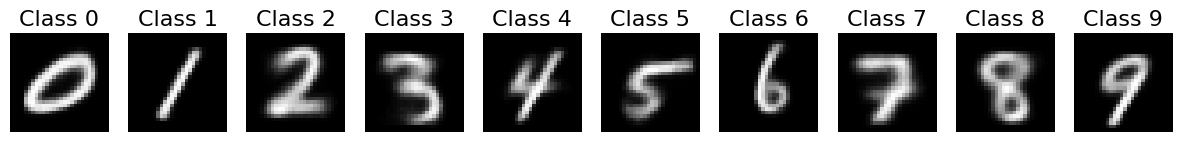


##################################################
CVAE-MLP Epoch [9/10], Loss: 12951.580222981771
Sample Images:


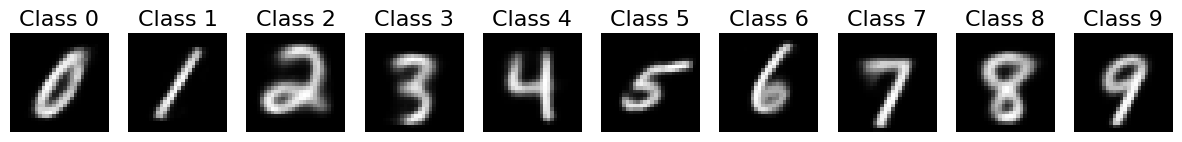


##################################################
CVAE-MLP Epoch [10/10], Loss: 12891.445340169272
Sample Images:


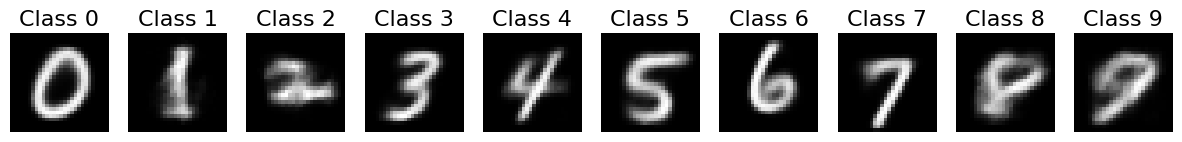

Best model saved as 'best_cvae_mlp_model.pth'


In [12]:
cvae_mlp = CVAE_MLP(x_dim, 512, 2, 10)
cvae_mlp = cvae_mlp.to(device)
train_cvae_mlp(cvae_mlp, train_loader)

# 3) Visualizing Latent Space Distribution in Two Models

In this section, we will visualize the latent space distribution for two different models:

## Latent Space Distribution:

### VAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in VAE model.
2. Analyze the characteristics of the distribution.

### CVAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in CVAE model.
2. Analyze the characteristics of the distribution.


Summarize your findings and draw conclusions based on the observed differences in the latent space distribution between VAE (MLP) and CVAE (MLP).


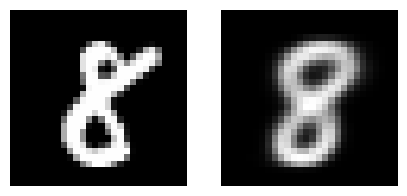

In [13]:
vae_mlp.eval()
latent_points = []
labels = []

with torch.no_grad():
    for i, (data, label) in enumerate(train_loader):
        data = data.to(device)
        recon, mu, _ = vae_mlp(data)

        latent_points.append(mu.cpu().numpy())
        labels.append(label.numpy())
        
        if i == 0:
            fig, axs = plt.subplots(1, 2, figsize=(5, 3))
            axs[0].imshow(data[0].squeeze().cpu(), cmap='gray')
            axs[0].axis('off')
            axs[1].imshow(recon.cpu()[0].reshape(shape=data[0].shape).squeeze().cpu(), cmap='gray')
            axs[1].axis('off')
            plt.show()

latent_points = np.concatenate(latent_points, axis=0)
labels = np.concatenate(labels, axis=0)

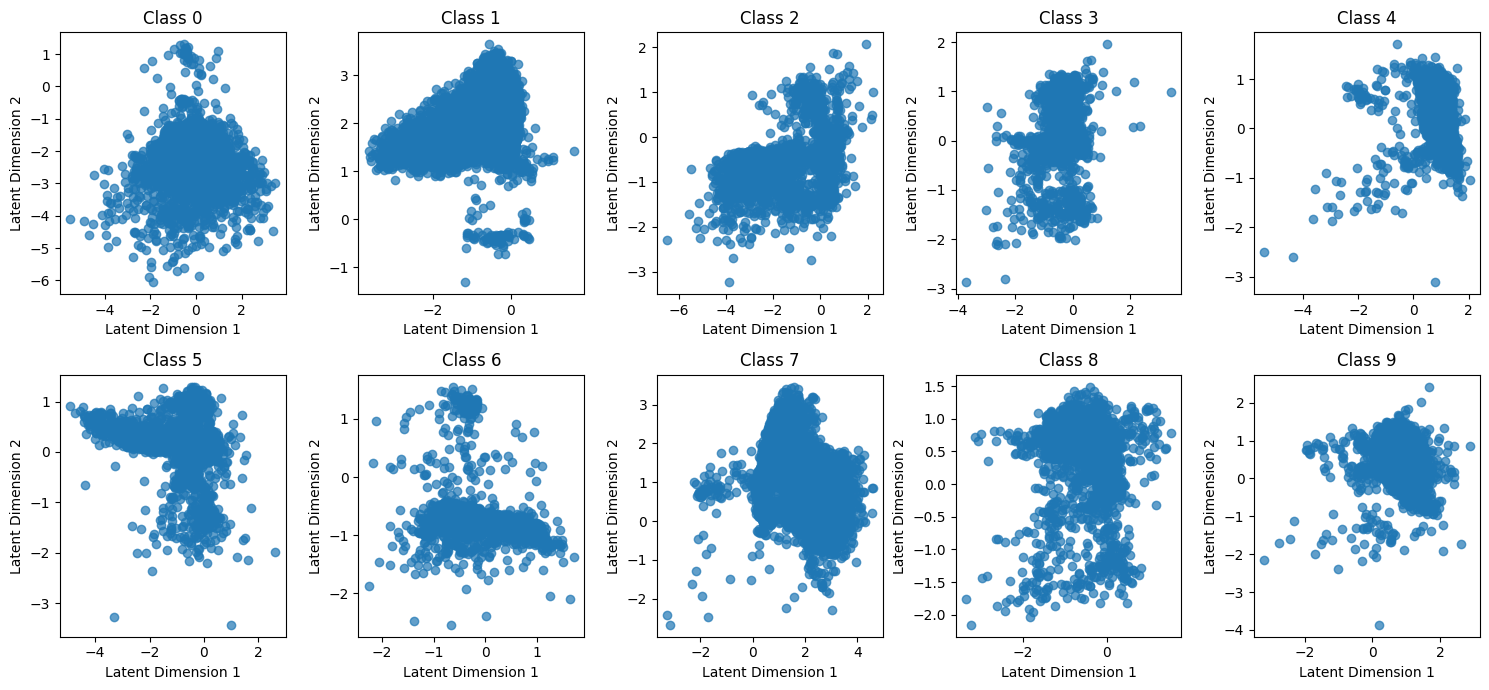

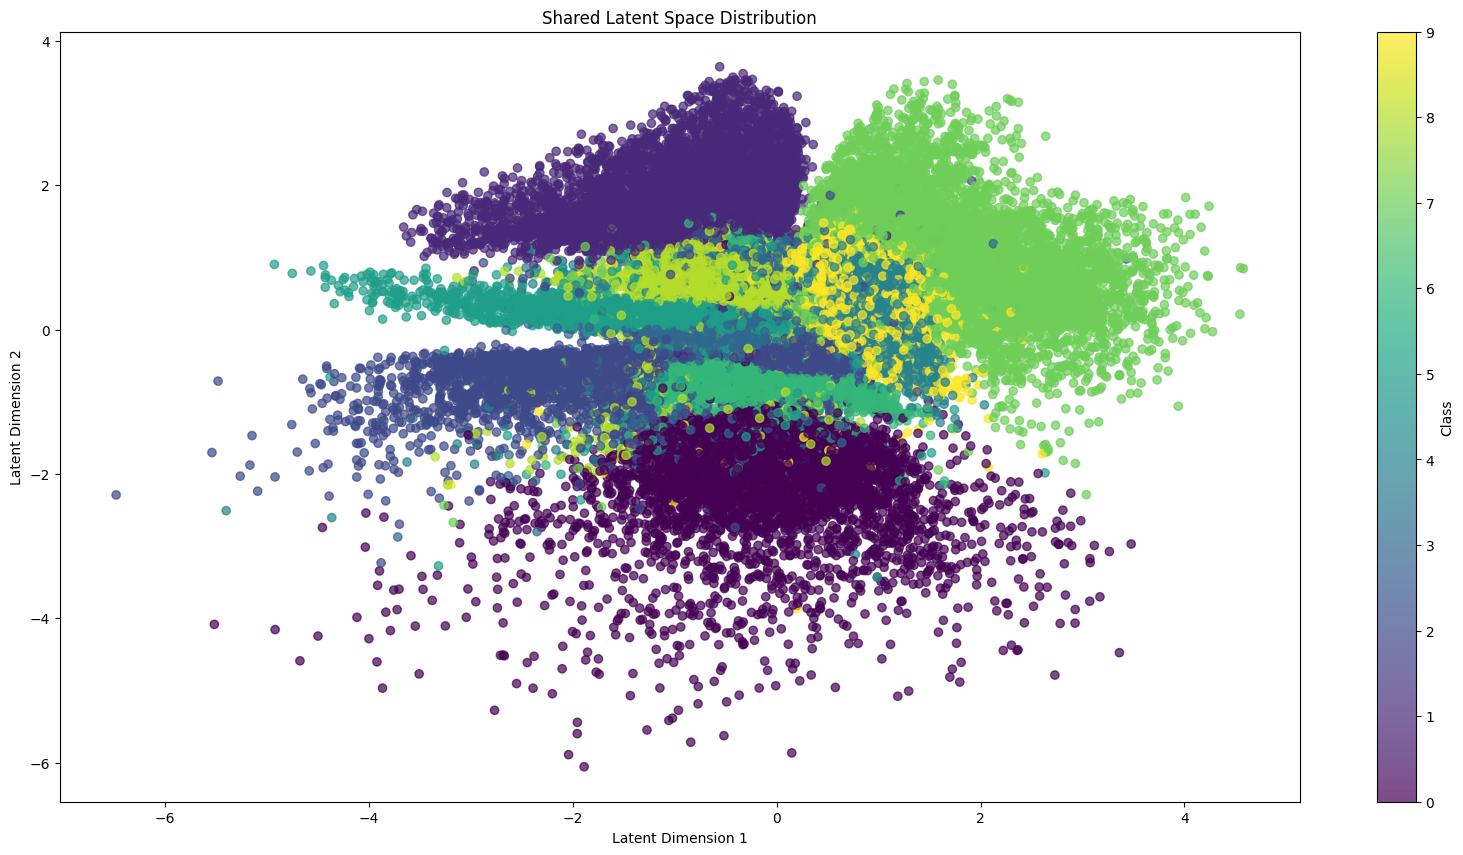

In [14]:
# Create subplots
rows, cols = 2, 5
fig, axes = plt.subplots(rows, cols, figsize=(15, 7))

# Iterate over each class label (0 to 9) and plot in the corresponding subplot
for class_label in range(10):
    # Select latent points and labels for the current class
    class_indices = np.where(labels == class_label)[0]
    class_latent_points = latent_points[class_indices]

    # Determine the subplot position
    row = class_label // cols
    col = class_label % cols

    # Plotting in the subplot
    scatter = axes[row, col].scatter(class_latent_points[:, 0], class_latent_points[:, 1], alpha=0.7)
    axes[row, col].set_title(f'Class {class_label}')
    axes[row, col].set_xlabel('Latent Dimension 1')
    axes[row, col].set_ylabel('Latent Dimension 2')

# Adjust layout to prevent clipping of titles
plt.tight_layout()
plt.show()

# Plotting
plt.figure(figsize=(20, 10))
scatter = plt.scatter(latent_points[:, 0], latent_points[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Class')
plt.title('Shared Latent Space Distribution')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.show()


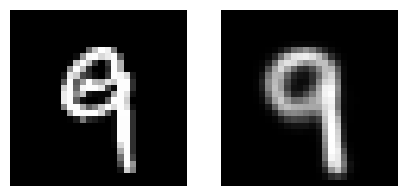

In [15]:
cvae_mlp.eval()
latent_points = []
labels = []

with torch.no_grad():
    for i, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        labels_one_hot = F.one_hot(label, num_classes=-1)
        recon, mu, logvar, class_logits = cvae_mlp(data, labels_one_hot)

        latent_points.append(mu.cpu().numpy())
        labels.append(label.cpu().numpy())
        
        if i == 0:
            fig, axs = plt.subplots(1, 2, figsize=(5, 3))
            axs[0].imshow(data[0].squeeze().cpu(), cmap='gray')
            axs[0].axis('off')
            axs[1].imshow(recon.cpu()[0].reshape(shape=data[0].shape).squeeze().cpu(), cmap='gray')
            axs[1].axis('off')
            plt.show()

latent_points = np.concatenate(latent_points, axis=0)
labels = np.concatenate(labels, axis=0)

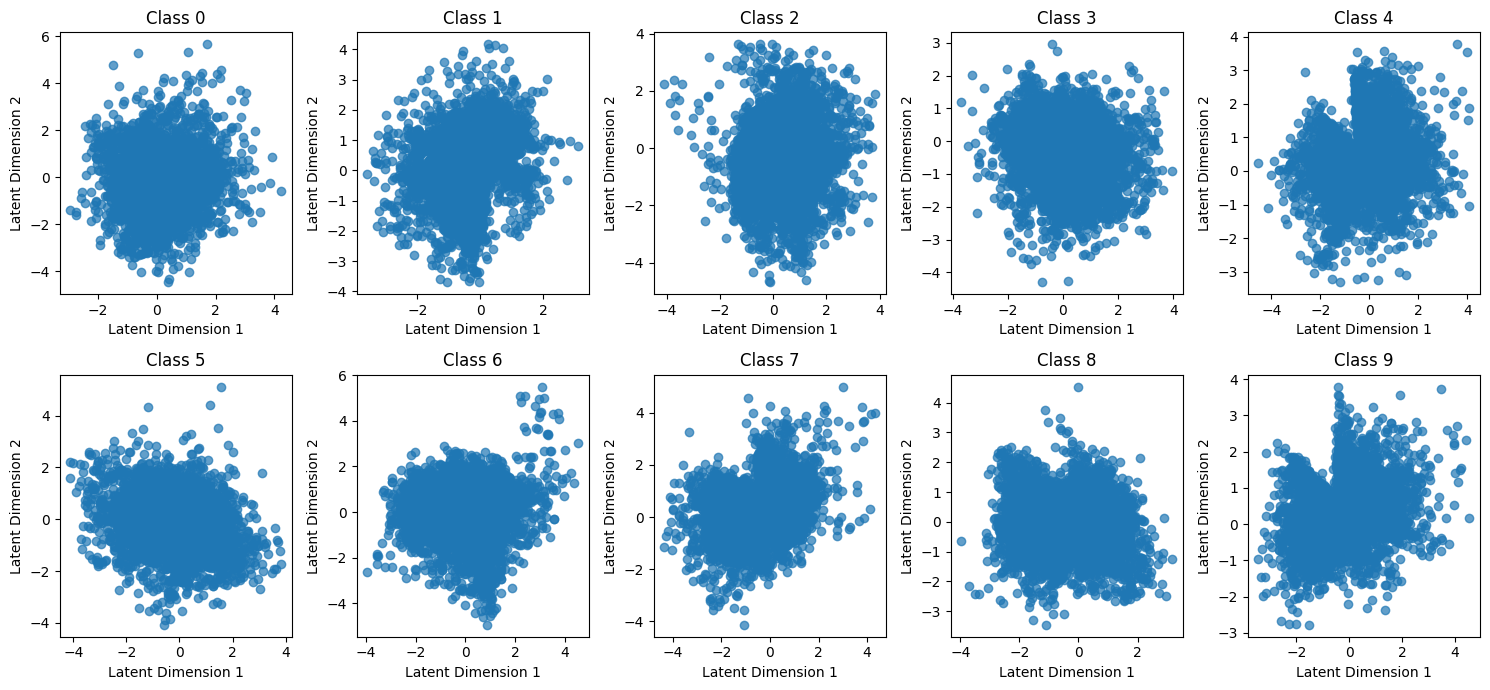

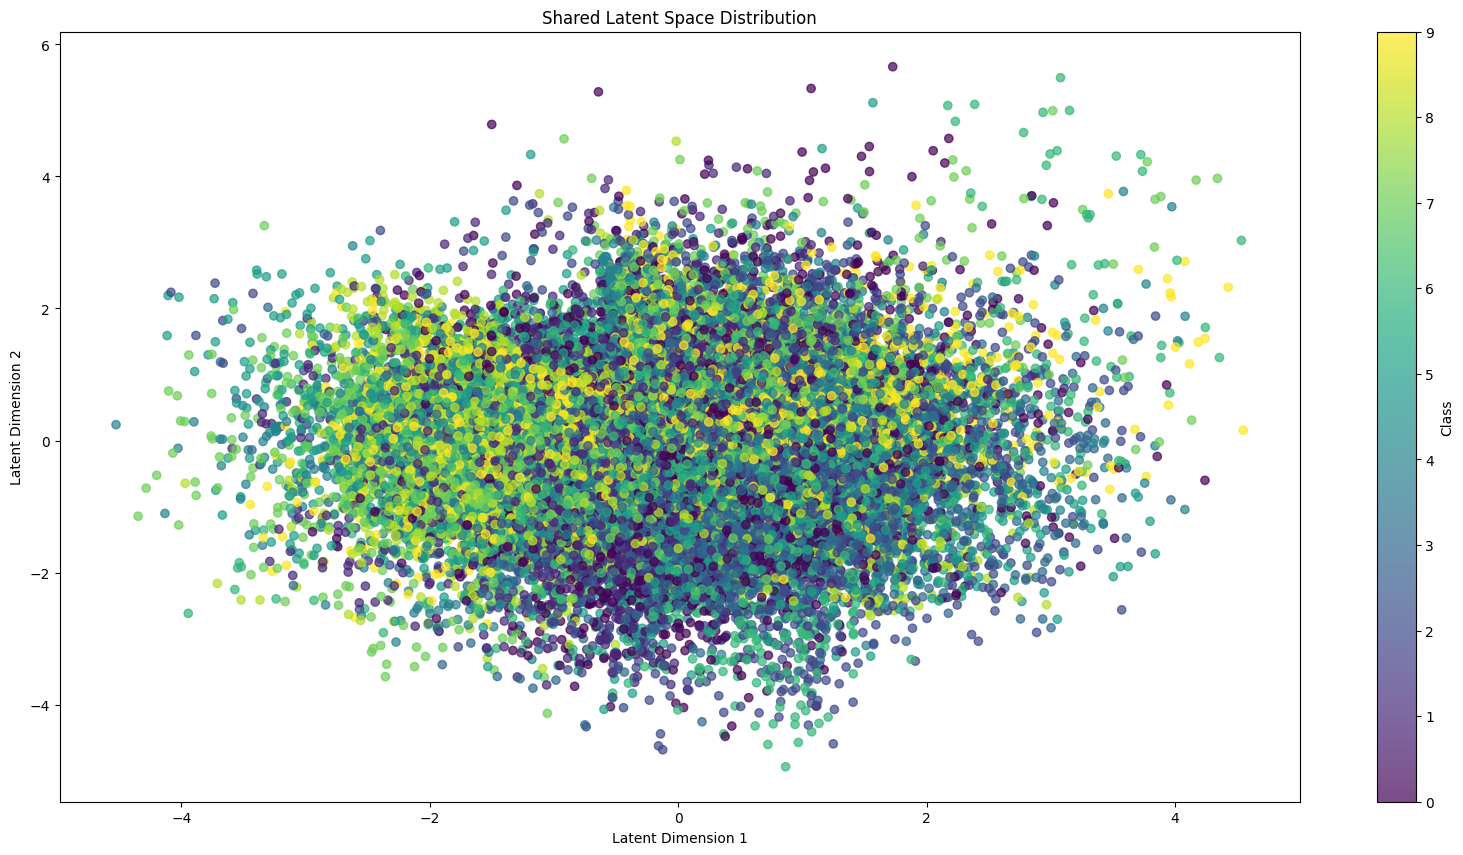

In [16]:
# Create subplots
rows, cols = 2, 5
fig, axes = plt.subplots(rows, cols, figsize=(15, 7))

# Iterate over each class label (0 to 9) and plot in the corresponding subplot
for class_label in range(10):
    # Select latent points and labels for the current class
    class_indices = np.where(labels == class_label)[0]
    class_latent_points = latent_points[class_indices]

    # Determine the subplot position
    row = class_label // cols
    col = class_label % cols

    # Plotting in the subplot
    scatter = axes[row, col].scatter(class_latent_points[:, 0], class_latent_points[:, 1], alpha=0.7)
    axes[row, col].set_title(f'Class {class_label}')
    axes[row, col].set_xlabel('Latent Dimension 1')
    axes[row, col].set_ylabel('Latent Dimension 2')

# Adjust layout to prevent clipping of titles
plt.tight_layout()
plt.show()

# Plotting
plt.figure(figsize=(20, 10))
scatter = plt.scatter(latent_points[:, 0], latent_points[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Class')
plt.title('Shared Latent Space Distribution')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.show()
